<a href="https://colab.research.google.com/github/arindamdeyofficial/Amazon_Review_Sentiment_Analysys/blob/main/Group_037_SEC_3_Assignment_2_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2 Set 5
Image Captioning
###Deep Learning (S1-21_DSECLZG524) - DL Group 037 - SEC-3
* Arindam Dey - 2020FC04251
* Kaushik Dubey - 2020FC04245
* Mohammad Attaullah - 2020FC04274

1.	Import Libraries/Dataset (0 mark) 
  1.	Import the required libraries
  2.	Check the GPU available (recommended- use free GPU provided by Google Colab)

In [1]:
import os
#COLAB_GPU
#print(os.environ )
isCollab = os.getenv('COLAB_GPU', False) and os.getenv('OS', True)
print('Collab' if isCollab else 'Local')

Collab


In [2]:
#libraries
import numpy as np 
import pandas as pd 
import random

# folder
import os

# Imports packages to view data
#pip install opencv-python
#pip install opencv-contrib-python
import cv2

#pip install glob2
from glob2 import glob

#pip install matplotlib
import matplotlib.pyplot as plt
from PIL import Image

#below only works in collab as it doesn't support imshow() directly in Google Collab
if isCollab:
    from google.colab.patches import cv2_imshow

#pip install prettytable
from prettytable import PrettyTable

# visu
import matplotlib.pyplot as plt
%matplotlib inline

#pip install seaborn
import seaborn as sns
plt.rc('image', cmap='gray')

# sklearn
#pip install scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow and keras
#pip install tensorflow
#pip install keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#google drive
#doesn't work in local
import pickle
if isCollab:
    from google.colab import drive
    drive.mount('/content/drive')

import sklearn.metrics as metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

Mounted at /content/drive


In [3]:
print(tf.__version__)

2.8.0


In [4]:
isCollab

True

2.	Data Processing(1  mark) 

### Read the pickle file 

In [5]:
if isCollab:
    drivemasterpath = '/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning'
else:
    drivemasterpath = 'D:/OneDrive/Certification/Bits Pilani Data Science/3rd Sem/Deep Learning (S1-21_DSECLZG524)/Assignment 2'
imgDatasetPath = drivemasterpath+"/Flicker8k_Dataset"
pklFilePath = drivemasterpath+'/set_0.pkl'
print(imgDatasetPath,pklFilePath)

/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/Flicker8k_Dataset /content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/set_0.pkl


In [7]:
infile = open(pklFilePath,'rb')
best_model = pickle.load(infile)

#keep dataobj into file
#import pickle
# dump : put the data of the object in a file
#pickle.dump(obj, open(file_path, "wb"))
# dumps : return the object in bytes
#data = pickle.dump(obj)

### Plot at least two samples and their captions (use matplotlib/seaborn/any other library). 

In [10]:
pics = os.listdir(imgDatasetPath)[25:30] # for 5 images we are showing

In [12]:
pic_address = [imgDatasetPath + '/' + pic for pic in pics]
pic_address

['/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/Flicker8k_Dataset/386656845_4e77c3e3da.jpg',
 '/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/Flicker8k_Dataset/387078972_514a38dc33.jpg',
 '/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/Flicker8k_Dataset/387830531_e89c192b92.jpg',
 '/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/Flicker8k_Dataset/387974450_bcd205daac.jpg',
 '/content/drive/My Drive/Colab Notebooks/AutoImageCaptioning/Flicker8k_Dataset/388386075_9ac3a89ada.jpg']

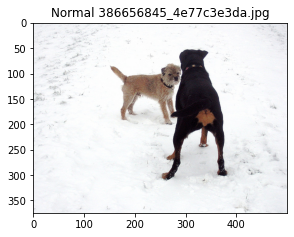

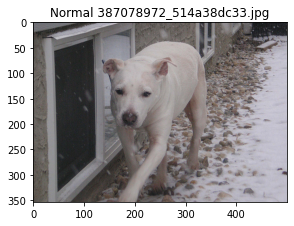

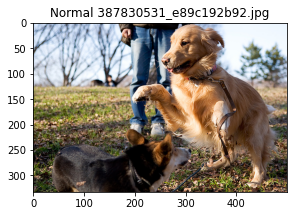

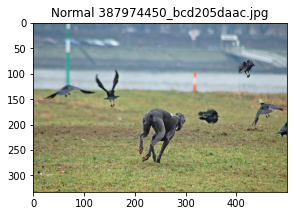

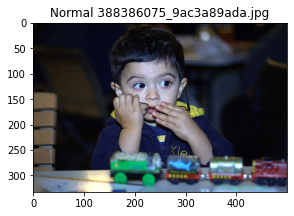

In [14]:
for i in range(0,5):
    # Load the images
    norm_img = Image.open(pic_address[i])

    #Let's plt these images
    ## plot normal picture
    f = plt.figure(figsize= (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(norm_img)
    a1.set_title(f'Normal {pics[i]}')


In [ ]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [ ]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

3.	Model Building (4 mark) 


1.	Use Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction.
2.	Create 3 layered LSTM layer model and other relevant layers for image caption generation.
3.	Add L2 regularization to all the LSTM layers. 
4.	Add one layer of dropout at the appropriate position and give reasons. 
5.	Choose the appropriate activation function for all the layers. 
6.	Print the model summary. 


Use Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction.

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

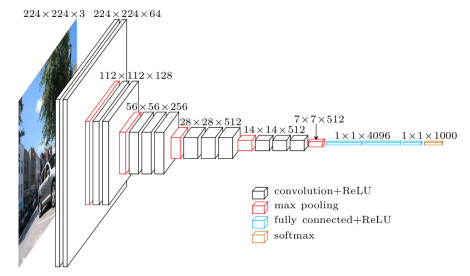

Pre-Trained Image Model (VGG16)
The following creates an instance of the VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

If include_top=True then the whole VGG16 model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will use some of the fully-connected layers in this pre-trained model, so we have to download the full model, but if you have a slow internet connection, then you can try and modify the code below to use the smaller pre-trained model without the classification layers.

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = image_model.get_layer('fc2')

In [ ]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [ ]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

Process All Images
We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="data",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="test", target_size=(224,224))

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Helper-function for processing all images in the validation-set.

In [ ]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [ ]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

NameError: ignored